# Analyze components driving changes in ni and ng during UEDGE run

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%config InlineBackend.figure_format = 'retina'
matplotlib.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['axes.grid.which'] = 'both'
matplotlib.rcParams['grid.color'] = '#dddddd'


def xsorCell(fnx, i, j):
    '''Particles/second in cell due to poloidal flow'''
    if i == com.ixpt1[0]+1 and j <= com.iysptrx:
        return fnx[com.ixpt2[0],j,0]-fnx[i,j,0]
    elif i == com.ixpt2[0]+1 and j <= com.iysptrx:
        return fnx[com.ixpt1[0],j,0]-fnx[i,j,0]
    else:
        return fnx[i-1,j,0]-fnx[i,j,0]

def ysorCell(fny, i, j):
    '''Particles/second in cell due to radial flow'''
    return fny[i,j-1,0]-fny[i,j,0]

def xsor(fnx):
    '''Particles/second in whole grid due to poloidal flow'''
    nx2, ny2, _ = fnx.shape
    out = np.zeros((nx2, ny2, 1))
    for ix in range(nx2):
        for iy in range(ny2):
            out[ix, iy, 0] = xsorCell(fnx, ix, iy)
    return out
            
def ysor(fny):
    '''Particles/second in whole grid due to radial flow'''
    nx2, ny2, _ = fny.shape
    out = np.zeros((nx2, ny2, 1))
    for ix in range(nx2):
        for iy in range(ny2):
            out[ix, iy, 0] = ysorCell(fny, ix, iy)
    return out

In [2]:
# Restore savefile (Settings from 'LR_diff_2.9MW_nc2.3e20_recyc0.99' + ineut and restart=0)
h = h5py.File('storeExt_ineut_r0.h5', 'r')
# Get successful iteration numbers (starting at 1, numbered incrementally)
iis = sorted([int(ii) for ii in h.keys()])

In [3]:
# Restore a case just to get com variables
from CMod import *
setGridfile('gridue_LR')
setup()
setDiffusiveNeutrals()
bbb.difni = 0.0 # D for radial hydrogen diffusion
bbb.kye = 0.0 # chi_e for radial elec energy diffusion
bbb.kyi = 0.0 # chi_i for radial ion energy diffusion
bbb.isbohmcalc = 0
bbb.facbee = 1.0 # factor for Bohm Te diffusion coeff 
bbb.facbei = 1.0 # factor for Bohm Ti diffusion coeff
bbb.facbni = 1.0 # factor for Bohm ni diffusion coeff
bbb.dif_use[:,:,0] = 0.2
bbb.kye_use = bbb.kyi_use = 0.1

bbb.ncore[0]=2.3e20
bbb.pcoree=bbb.pcorei=1.45e6 
bbb.recycp[0]=bbb.recycw[0]=0.99
rest('LR_diff_2.9MW_nc2.3e20_recyc0.99')
# This storeExt is the product of the following further commands:
#rest('step/uyewposz')
#bbb.afracs=.003
#rundtp(storeExt=True, storeName='storeExt_5MW.h5')

# UEDGE version: 7.0.9.2.2
File attributes:
     written on:  Fri May 21 16:31:02 2021
        by code:  UEDGE
       version:  [b'$Name: V7_09_02 $']
    physics tag:  [b'$Name: V7_09_02 $']
 python version:  7.0.9.2.2


In [6]:
ix = com.nx
iy = com.iysptrx+1

dts = [1e-10]
nis = np.array([h[str(ii)]['ni'][ix,iy,0] for ii in iis])
ngs = np.array([h[str(ii)]['ng'][ix,iy,0] for ii in iis])
tis = np.array([h[str(ii)]['ti'][ix,iy] for ii in iis])/bbb.ev
tes = np.array([h[str(ii)]['te'][ix,iy] for ii in iis])/bbb.ev
for i in iis:
    if i == 1:
        continue
    # Reconstruct ni and ng by time integration
    hii = h[str(i)]
    dt = hii['dtreal'][()]
    dts.append(float(dt))
    
dts = np.array(dts)
dt_tots = np.cumsum(dts)

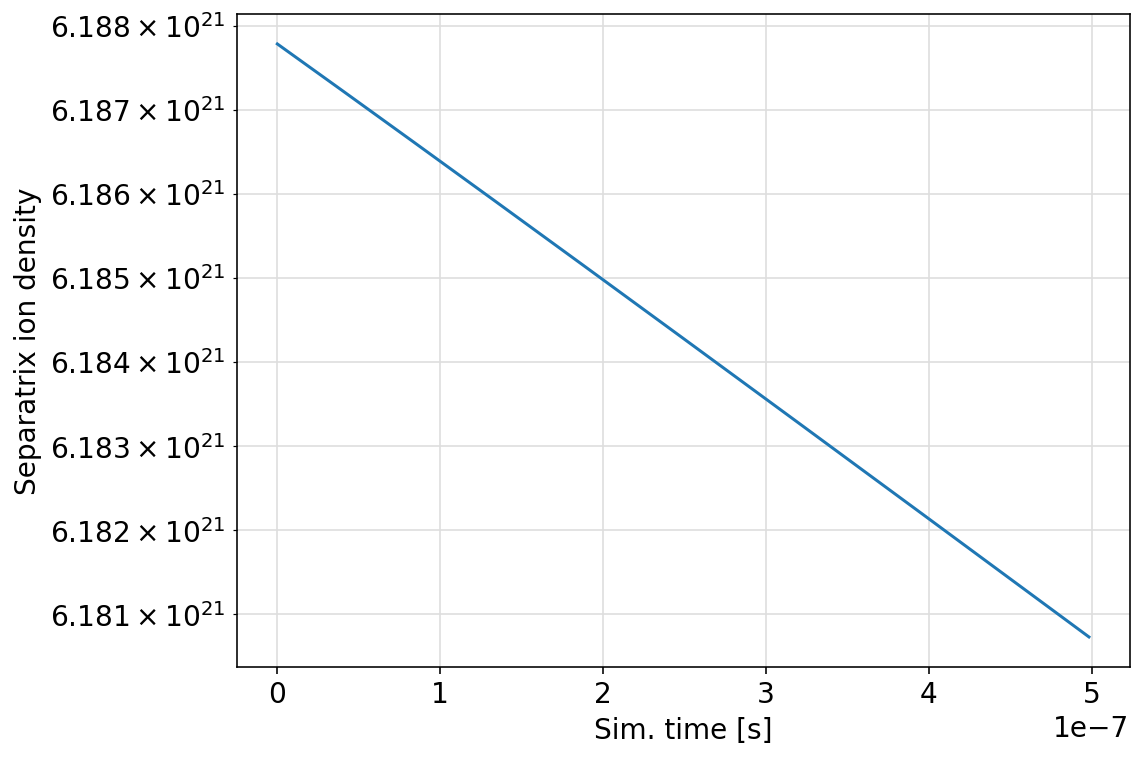

In [16]:
plt.plot(dt_tots, nis)
plt.yscale('log')
plt.ylabel('Separatrix ion density');
plt.xlabel('Sim. time [s]');

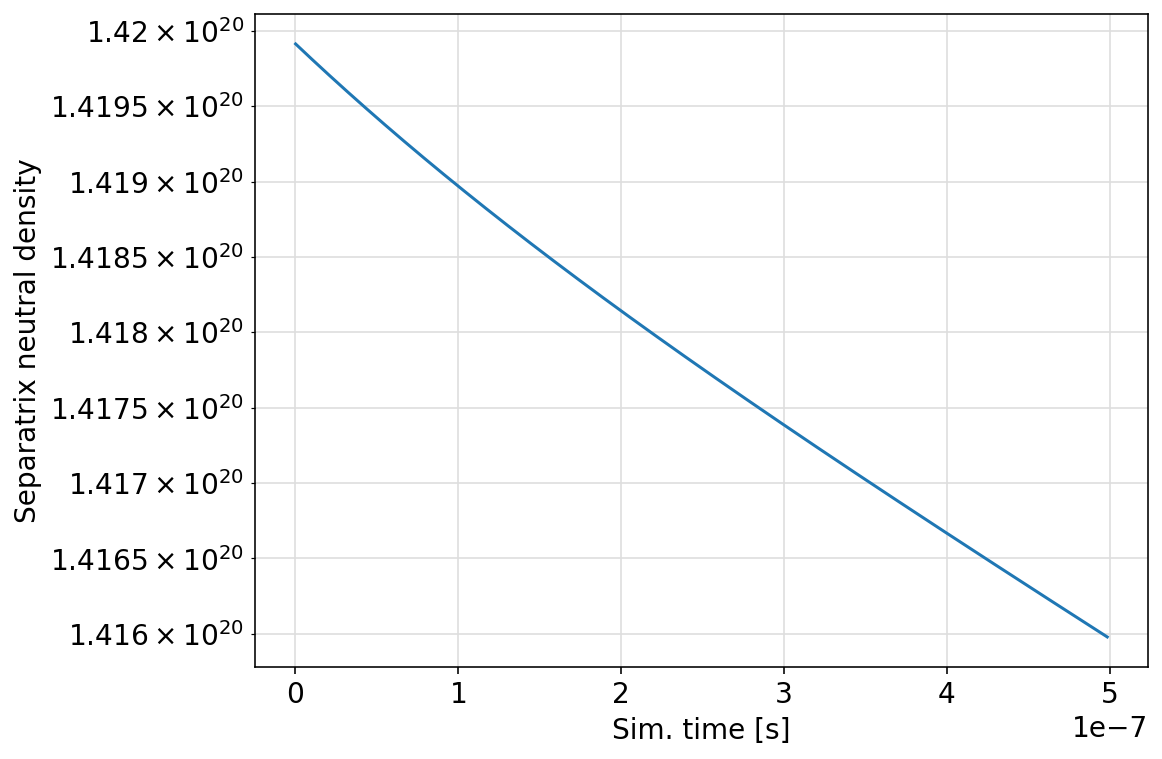

In [15]:
plt.plot(dt_tots, ngs)
plt.yscale('log')
plt.ylabel('Separatrix neutral density');
plt.xlabel('Sim. time [s]');

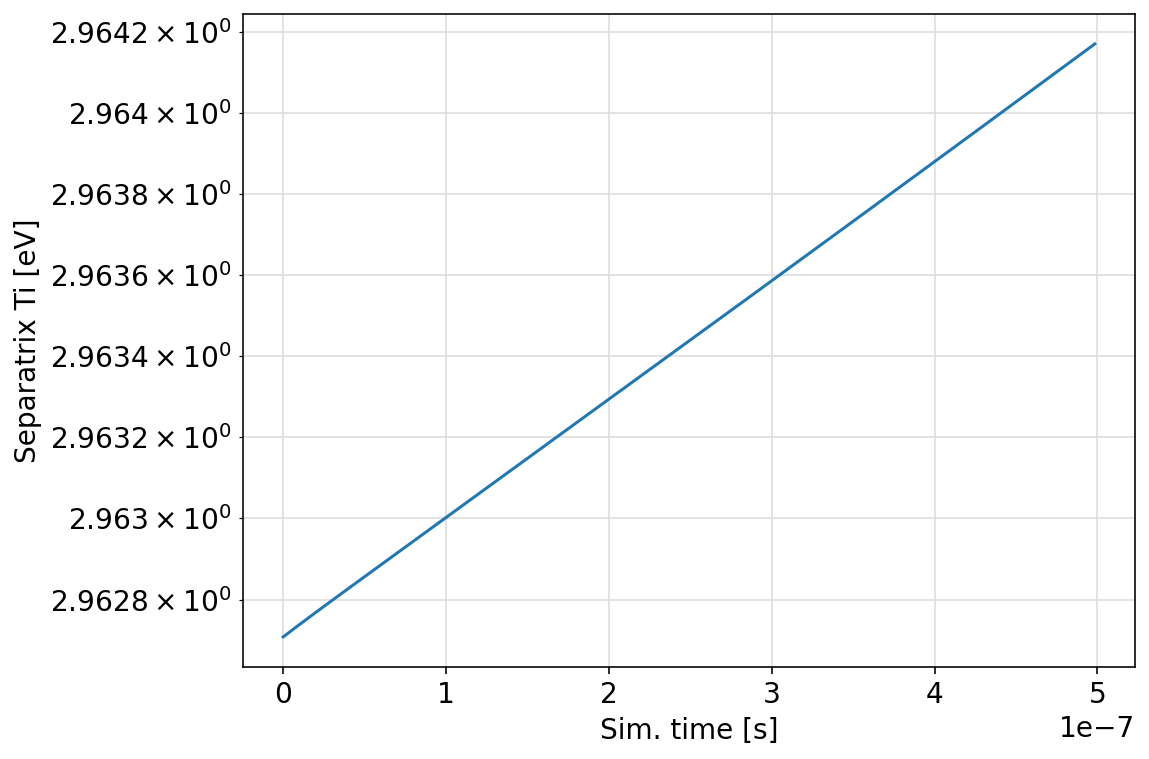

In [23]:
plt.plot(dt_tots, tis)
plt.yscale('log')
plt.ylabel('Separatrix Ti [eV]');
plt.xlabel('Sim. time [s]');

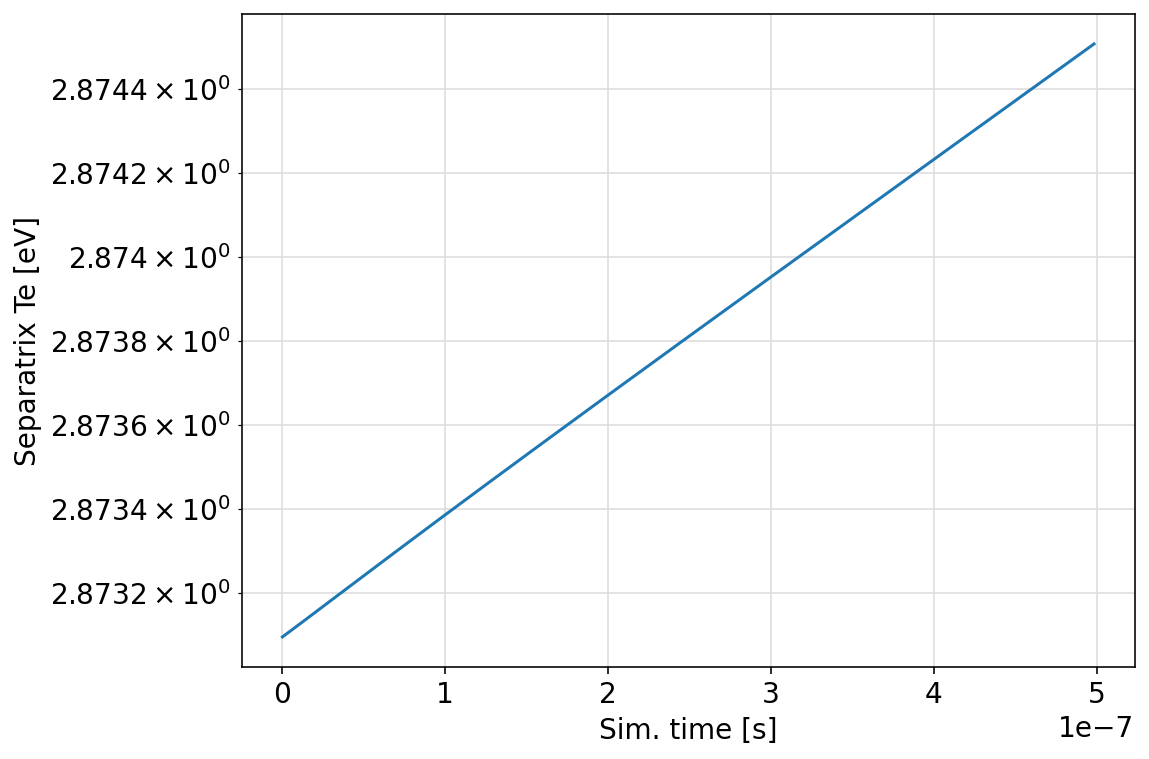

In [19]:
plt.plot(dt_tots, tes)
plt.yscale('log')
plt.ylabel('Separatrix Te [eV]');
plt.xlabel('Sim. time [s]');